In [12]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import plot_roc_curve, roc_auc_score,confusion_matrix
from sklearn.tree import export_graphviz
from joblib import dump,load
import pydot
from sklearn.decomposition import PCA
import itertools



In [5]:
# Function to plot Confusion Matrix (to be used later).
# #found on https://www.kaggle.com/sid321axn/fraud-detection-deep-learning-with-smote
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

We will test to see if our data is imbalanced.

In [6]:
training_data = pd.read_csv("full_training_data_1988-2016")
#numbers of players in training data that are All-NBA players and aren't All-NBA players
counter = Counter(training_data.All_NBA)
print(counter)
#percentage of All-NBA
print("Percent All-NBA:",round(len(training_data.loc[training_data.All_NBA == True])/len(training_data.index)*100,2))
#percentage of non All-NBA
print("Percent not All-NBA:",round(len(training_data.loc[training_data.All_NBA == False])/len(training_data.index)*100,2))


Counter({False: 11784, True: 420})
Percent All-NBA: 3.44
Percent not All-NBA: 96.56


As we can see, the amount of players in our training data that aren't labeled as All-NBA are approx. 97% of our data. Therefore, our data is imbalanced. We will need to be balance our training data in order to help our classification algorithm. Therefore, we will perform SMOTE to synthetically build more examples of the minority class. In this instance, the minority class is the players that have made an All-NBA team.

In [7]:
X = training_data.iloc[:,1:-1].select_dtypes(exclude=['object'])
y = training_data["All_NBA"]


As we can see, the data is now equal. As mentioned in multiple articles, SMOTE works best with random under-sampling of the majority class. We have set up both SMOTE by itself and SMOTE with under-sampling.

We will first create a Random Forest model to predict All-NBA teams

In [8]:
#parameter grid to help with hyper-parameter tuning
param_grid = [
    {'n_estimators': [50,100,250,300,500],
     'criterion': ["gini","entropy"],
     'max_features': ['auto','log2'],
     'min_samples_leaf': [1,2,3,5]},
    ]

# cv = RepeatedStratifiedKFold(n_splits=10)
# train Random Forest
# rf = RandomForestClassifier()
# grid_search_rf = GridSearchCV(rf,param_grid=param_grid,cv=cv,n_jobs=-1)
#best model is 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300} using cv for 5
#best model after KFold is {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 250}

grid_search_rf = RandomForestClassifier(criterion='entropy',max_features='log2',min_samples_leaf=1,n_estimators=250)
grid_search_rf.fit(X,y=y)
# print(grid_search_rf.best_params_)


RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=250)

In [9]:
#function to calculate Top 15 All-NBA players
def grabTop15Players(dataframe1, dataframe2):
    guard_counter = 0
    forward_counter = 0
    center_counter = 0
    top_all_nba = []
    true_all_NBA = dataframe1.loc[dataframe1.All_NBA == True,"Player"]
    dataframe1["Predicted_Prob"] = grid_search_rf.predict_proba(dataframe2)[:,1]
    filtered_df = dataframe1.reindex(columns = ['Player','Pos','Predicted_Prob'])
    sorted_filtered_df = filtered_df.sort_values(by='Predicted_Prob',ascending=False).loc[filtered_df["Predicted_Prob"] != 0]   

    for player in range(len(sorted_filtered_df.index)):
        if sorted_filtered_df.iloc[player,:]["Pos"] == "PG" or sorted_filtered_df.iloc[player,:]["Pos"] == "SG":
            if(guard_counter < 6):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                guard_counter += 1
        elif sorted_filtered_df.iloc[player,:]["Pos"] == "SF" or sorted_filtered_df.iloc[player,:]["Pos"] == "PF":
            if(forward_counter < 6):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                forward_counter += 1
        elif sorted_filtered_df.iloc[player,:]["Pos"] == "C":
            if(center_counter < 3):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                center_counter += 1
    
    print("True Top 15 Players:",true_all_NBA)
    print("Predicted Top 15 Players:", top_all_nba)
    wrong_predict_players = [players for players in top_all_nba if players not in true_all_NBA.unique()]
    print("Top 15 predicted players who didn't make All-NBA:", wrong_predict_players)
    print()
    missed_players = [players for players in true_all_NBA.unique() if players not in top_all_nba]
    print("Top 15 players who werent predicted top 15:",missed_players)
    print()
    print("Percent correct of Top 15 Players:",(15-len(wrong_predict_players))/15)      
   
    


In [10]:
#testing random forest model on testing data
test_data = pd.read_csv("testing_data_2017-2020")
test_player_data_all = test_data.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class_all = test_data["All_NBA"]

2017 Data

0.977366255144033
86            Mike Conley
89       DeMarcus Cousins
167         Blake Griffin
184        Gordon Hayward
214          Kyrie Irving
265        Damian Lillard
273            Kyle Lowry
350            Chris Paul
433    Karl-Anthony Towns
Name: Player, dtype: object

163    Draymond Green
239    DeAndre Jordan
Name: Player, dtype: object

0.9941967445152159


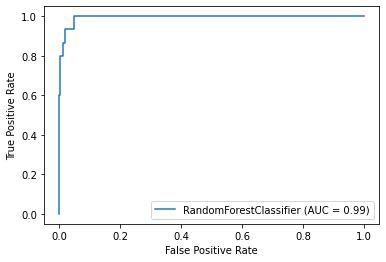

True Top 15 Players: 15     Giannis Antetokounmpo
65              Jimmy Butler
97             Stephen Curry
99             Anthony Davis
107            DeMar DeRozan
118             Kevin Durant
154              Rudy Gobert
163           Draymond Green
171             James Harden
219             LeBron James
239           DeAndre Jordan
260            Kawhi Leonard
424            Isaiah Thomas
452                John Wall
457        Russell Westbrook
Name: Player, dtype: object
Predicted Top 15 Players: ['Giannis Antetokounmpo', 'LeBron James', 'Kawhi Leonard', 'Anthony Davis', 'Kevin Durant', 'Russell Westbrook', 'Stephen Curry', 'DeMar DeRozan', 'Jimmy Butler', 'Karl-Anthony Towns', 'James Harden', 'Isaiah Thomas', 'John Wall', 'DeMarcus Cousins', 'Gordon Hayward']
Top 15 predicted players who didn't make All-NBA: ['Karl-Anthony Towns', 'DeMarcus Cousins', 'Gordon Hayward']

Top 15 players who werent predicted top 15: ['Rudy Gobert', 'Draymond Green', 'DeAndre Jordan']

Percent corr

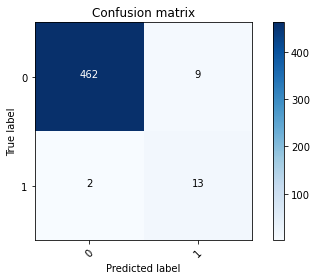

In [19]:
#testing 2017 data
test_data2017 = test_data[test_data['Year'] == 2017]
test_player_data2017 = test_data2017.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2017 = test_data2017["All_NBA"]

print(grid_search_rf.score(test_player_data2017,test_player_class2017))
predicted_y = grid_search_rf.predict(test_player_data2017)
test_data2017["Predicted_All_NBA"] = predicted_y

# predict_all_nba = test_data2017.loc[test_data2017.Predicted_All_NBA == True,"Player"]

#players predicted to be on All-NBA and were not on All-NBA
print(test_data2017.loc[(test_data2017.All_NBA == False) & (test_data2017.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2017.loc[(test_data2017.All_NBA == True) & (test_data2017.Predicted_All_NBA == False),"Player"])
print()

# compute ROC AUC score
print(roc_auc_score(test_player_class2017,grid_search_rf.predict_proba(test_player_data2017)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2017,test_player_class2017)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2017,test_player_data2017)
matrix = confusion_matrix(test_player_class2017,predicted_y)
plot_confusion_matrix(matrix,classes=[0,1])
plt.savefig('2017_rf_confusion_matrix.png')



2018 Data

0.9888888888888889
492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curry
607            Anthony Davis
615            DeMar DeRozan
628             Kevin Durant
632              Joel Embiid
658              Paul George
679             James Harden
733             LeBron James
783           Damian Lillard
867           Victor Oladipo
969       Karl-Anthony Towns
993        Russell Westbrook
Name: Player, dtype: object

492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curry
607            Anthony Davis
628             Kevin Durant
679             James Harden
724             Kyrie Irving
733             LeBron James
748             Nikola Jokić
783           Damian Lillard
867           Victor Oladipo
881               Chris Paul
969       Karl-Anthony Towns
993        Russell Westbrook
Name: Player, dtype: object

724    Kyrie Irving
748    Nikola Jokić
881      Chri

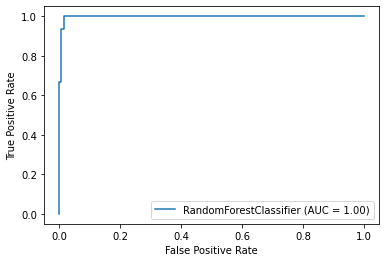

True Top 15 Players: 492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curry
607            Anthony Davis
615            DeMar DeRozan
628             Kevin Durant
632              Joel Embiid
658              Paul George
679             James Harden
733             LeBron James
783           Damian Lillard
867           Victor Oladipo
969       Karl-Anthony Towns
993        Russell Westbrook
Name: Player, dtype: object
Predicted Top 15 Players: ['Giannis Antetokounmpo', 'Anthony Davis', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Kevin Durant', 'LaMarcus Aldridge', 'Damian Lillard', 'Stephen Curry', 'Karl-Anthony Towns', 'Nikola Jokić', 'Kyrie Irving', 'Victor Oladipo', 'Paul George', 'Kristaps Porziņģis']
Top 15 predicted players who didn't make All-NBA: ['Nikola Jokić', 'Kyrie Irving', 'Kristaps Porziņģis']

Top 15 players who werent predicted top 15: ['Jimmy Butler', 'DeMar DeRozan', 'Joel Embiid']

Percent corre

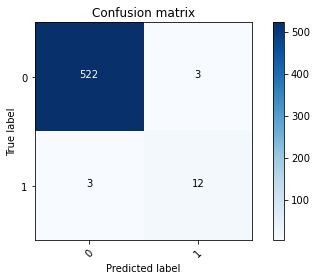

In [20]:
#testing 2018 data
test_data2018 = test_data[test_data['Year'] == 2018]
test_player_data2018 = test_data2018.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2018 = test_data2018["All_NBA"]

print(grid_search_rf.score(test_player_data2018,test_player_class2018))
predicted_y = grid_search_rf.predict(test_player_data2018)
test_data2018["Predicted_All_NBA"] = predicted_y

print(test_data2018.loc[test_data2018.All_NBA == True,"Player"])
print()
print(test_data2018.loc[test_data2018.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2018.loc[(test_data2018.All_NBA == False) & (test_data2018.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2018.loc[(test_data2018.All_NBA == True) & (test_data2018.Predicted_All_NBA == False),"Player"])


#compute ROC AUC score
print(roc_auc_score(test_player_class2018,grid_search_rf.predict_proba(test_player_data2018)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2018,test_player_class2018)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2018,test_player_data2018)
matrix = confusion_matrix(test_player_class2018,predicted_y)
plot_confusion_matrix(matrix,classes=[0,1])
plt.savefig('2018_rf_confusion_matrix.png')


2019 Data

0.9886792452830189
1043    Giannis Antetokounmpo
1149            Stephen Curry
1175             Kevin Durant
1180              Joel Embiid
1208              Paul George
1212              Rudy Gobert
1227            Blake Griffin
1231             James Harden
1274             Kyrie Irving
1283             LeBron James
1294             Nikola Jokić
1326            Kawhi Leonard
1330           Damian Lillard
1522             Kemba Walker
1531        Russell Westbrook
Name: Player, dtype: object

1043    Giannis Antetokounmpo
1149            Stephen Curry
1151            Anthony Davis
1172           Andre Drummond
1175             Kevin Durant
1180              Joel Embiid
1208              Paul George
1212              Rudy Gobert
1231             James Harden
1274             Kyrie Irving
1283             LeBron James
1294             Nikola Jokić
1326            Kawhi Leonard
1330           Damian Lillard
1506       Karl-Anthony Towns
1518           Nikola Vučević
1531        Russell We

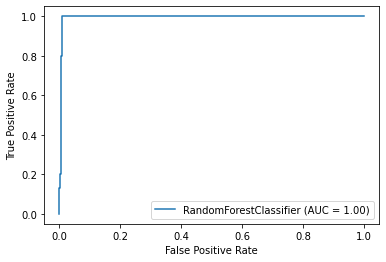

True Top 15 Players: 1043    Giannis Antetokounmpo
1149            Stephen Curry
1175             Kevin Durant
1180              Joel Embiid
1208              Paul George
1212              Rudy Gobert
1227            Blake Griffin
1231             James Harden
1274             Kyrie Irving
1283             LeBron James
1294             Nikola Jokić
1326            Kawhi Leonard
1330           Damian Lillard
1522             Kemba Walker
1531        Russell Westbrook
Name: Player, dtype: object
Predicted Top 15 Players: ['Giannis Antetokounmpo', 'Kevin Durant', 'Anthony Davis', 'James Harden', 'Karl-Anthony Towns', 'Kawhi Leonard', 'Nikola Jokić', 'Paul George', 'LeBron James', 'Damian Lillard', 'Stephen Curry', 'Kyrie Irving', 'Russell Westbrook', 'Blake Griffin', 'Kemba Walker']
Top 15 predicted players who didn't make All-NBA: ['Anthony Davis', 'Karl-Anthony Towns']

Top 15 players who werent predicted top 15: ['Joel Embiid', 'Rudy Gobert']

Percent correct of Top 15 Players: 0.86666

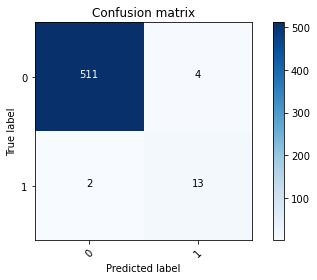

In [21]:
#testing 2019 data
test_data2019 = test_data[test_data['Year'] == 2019]
test_player_data2019 = test_data2019.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2019 = test_data2019["All_NBA"]

print(grid_search_rf.score(test_player_data2019,test_player_class2019))
predicted_y = grid_search_rf.predict(test_player_data2019)
test_data2019["Predicted_All_NBA"] = predicted_y

print(test_data2019.loc[test_data2019.All_NBA == True,"Player"])
print()
print(test_data2019.loc[test_data2019.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2019.loc[(test_data2019.All_NBA == False) & (test_data2019.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2019.loc[(test_data2019.All_NBA == True) & (test_data2019.Predicted_All_NBA == False),"Player"])
print()

#compute ROC AUC score
print(roc_auc_score(test_player_class2019,grid_search_rf.predict_proba(test_player_data2019)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2019,test_player_class2019)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2019,test_player_data2019)
matrix = confusion_matrix(test_player_class2019,predicted_y)
plot_confusion_matrix(matrix,classes=[0,1])
plt.savefig('2019_rf_confusion_matrix.png')


2020 Data

0.9867674858223062
1568    Giannis Antetokounmpo
1637             Jimmy Butler
1678            Anthony Davis
1689              Luka Dončić
1731              Rudy Gobert
1753             James Harden
1805             LeBron James
1816             Nikola Jokić
1849            Kawhi Leonard
1852           Damian Lillard
1951               Chris Paul
2004            Pascal Siakam
2006              Ben Simmons
2019             Jayson Tatum
2061        Russell Westbrook
Name: Player, dtype: object

1568    Giannis Antetokounmpo
1678            Anthony Davis
1689              Luka Dončić
1753             James Harden
1805             LeBron James
1816             Nikola Jokić
1849            Kawhi Leonard
1852           Damian Lillard
Name: Player, dtype: object

Series([], Name: Player, dtype: object)

1637         Jimmy Butler
1731          Rudy Gobert
1951           Chris Paul
2004        Pascal Siakam
2006          Ben Simmons
2019         Jayson Tatum
2061    Russell Westbrook
Name: Play

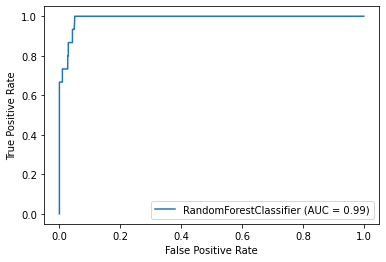

True Top 15 Players: 1568    Giannis Antetokounmpo
1637             Jimmy Butler
1678            Anthony Davis
1689              Luka Dončić
1731              Rudy Gobert
1753             James Harden
1805             LeBron James
1816             Nikola Jokić
1849            Kawhi Leonard
1852           Damian Lillard
1951               Chris Paul
2004            Pascal Siakam
2006              Ben Simmons
2019             Jayson Tatum
2061        Russell Westbrook
Name: Player, dtype: object
Predicted Top 15 Players: ['Anthony Davis', 'Giannis Antetokounmpo', 'Kawhi Leonard', 'LeBron James', 'James Harden', 'Luka Dončić', 'Damian Lillard', 'Nikola Jokić', 'Rudy Gobert', 'Russell Westbrook', 'Bradley Beal', 'Joel Embiid', 'Jimmy Butler', 'Domantas Sabonis', 'Khris Middleton']
Top 15 predicted players who didn't make All-NBA: ['Bradley Beal', 'Joel Embiid', 'Domantas Sabonis', 'Khris Middleton']

Top 15 players who werent predicted top 15: ['Chris Paul', 'Pascal Siakam', 'Ben Simmons',

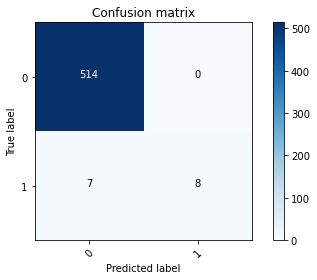

In [22]:
#testing 2020 data
test_data2020 = test_data[test_data['Year'] == 2020]
test_player_data2020 = test_data2020.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2020 = test_data2020["All_NBA"]

print(grid_search_rf.score(test_player_data2020,test_player_class2020))
predicted_y = grid_search_rf.predict(test_player_data2020)
test_data2020["Predicted_All_NBA"] = predicted_y

print(test_data2020.loc[test_data2020.All_NBA == True,"Player"])
print()
print(test_data2020.loc[test_data2020.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2020.loc[(test_data2020.All_NBA == False) & (test_data2020.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2020.loc[(test_data2020.All_NBA == True) & (test_data2020.Predicted_All_NBA == False),"Player"])
print()

#compute ROC AUC score
print(roc_auc_score(test_player_class2020,grid_search_rf.predict_proba(test_player_data2020)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2020,test_player_class2020)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2020,test_player_data2020)
matrix = confusion_matrix(test_player_class2020,predicted_y)
plot_confusion_matrix(matrix,classes=[0,1])
plt.savefig('2020_rf_confusion_matrix.png')

Variable: WS_advanced, Importance:0.0808
Variable: VORP_advanced, Importance:0.0703
Variable: PER_advanced, Importance:0.0697
Variable: BPM_advanced, Importance:0.0472
Variable: WS/48_advanced, Importance:0.041
Variable: FG_per_game, Importance:0.0409
Variable: PTS_per_game, Importance:0.0375
Variable: OWS_advanced, Importance:0.036
Variable: OBPM_advanced, Importance:0.0333
Variable: PTS_per_minute, Importance:0.0271
Variable: MP, Importance:0.0263
Variable: FTA_per_game, Importance:0.0258
Variable: PTS_per_poss, Importance:0.0237
Variable: 2P_per_game, Importance:0.0233
Variable: DWS_advanced, Importance:0.0215
Variable: TOV_per_game, Importance:0.0206
Variable: FGA_per_game, Importance:0.0203
Variable: FT_per_game, Importance:0.0192
Variable: 2PA_per_game, Importance:0.0171
Variable: USG%_advanced, Importance:0.0116
Variable: DRB_per_game, Importance:0.011
Variable: AST_per_game, Importance:0.0097
Variable: FT_per_poss, Importance:0.0097
Variable: FG_per_poss, Importance:0.009
Varia

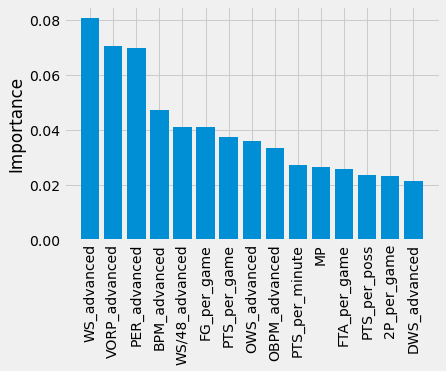

In [21]:
#calculating feature importance
importances = grid_search_rf.feature_importances_

feature_importances = [(feature,round(importance,4)) for feature, importance in zip(list(X.columns),importances)]

sorted_features = sorted(feature_importances,key= lambda x: x[1], reverse=True)
[print("Variable: {}, Importance:{}".format(*pair)) for pair in sorted_features]

plt.style.use("fivethirtyeight")
#un-sorted columns
# x_values = list(range(len(importances)))
# plt.bar(x_values,list(importances),tick_label=X.columns)

#sorted columns
sorted_feature_names = [name[0] for name in sorted_features]
sorted_feature_values = [value[1] for value in sorted_features]
print(sorted_feature_values)

plt.bar(list(range(15)),sorted_feature_values[:15])
plt.xticks(list(range(15)),sorted_feature_names[:15],rotation='vertical')
plt.ylabel("Importance")
plt.savefig('random_forest.png',bbox_inches="tight")




Save model for further use

In [54]:
dump(grid_search_rf,"grid_rf.joblib")

['grid_rf.joblib']

Creating Image of Random Forest

In [25]:
#choose random tree to visualize
rand_num = np.random.randint(250)
tree = grid_search_rf.estimators_[rand_num]

export_graphviz(tree,out_file = 'tree.dot',feature_names=X.columns)
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('rf_tree.png')

